## Importing libraries
---------------

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from functools import reduce

## Reading Files
---------------

In [2]:
# Finding CABRa attributes csv files
path_files = pathlib.Path('CABRa_attributes_csv/')
cabra_attributes_files = path_files.rglob('*.csv')

In [3]:
# Reading files
dfs = []
for file in cabra_attributes_files:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=';')
    dfs.append(df)

CABRa_attributes_csv\CABra_dataset _Additional_attributes.csv
CABRa_attributes_csv\CABra_dataset _Climate_attributes.csv
CABRa_attributes_csv\CABra_dataset_Groundwater_attributes.csv
CABRa_attributes_csv\CABra_dataset_Hydrologic_disturbance_attributes.csv
CABRa_attributes_csv\CABra_dataset_Land_cover_attributes.csv
CABRa_attributes_csv\CABra_dataset_Streamflow_attributes.csv
CABRa_attributes_csv\cabra_general_attributes.csv
CABRa_attributes_csv\cabra_Geology_attributes.csv
CABRa_attributes_csv\CABra_soil_attributes.csv
CABRa_attributes_csv\CABra_topography_attributes.csv


## Creating Dataset and calculating variables
-----------------------

In [4]:
# Merging DataFrames
df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [5]:
df_merged.head()

,CABra ID,ANA ID,longitude_centroid,latitude_centroid,dist_coast,clim_p,clim_tmin,clim_tmax,clim_rh,clim_wind,...,soil_carbon,soil_bulk,soil_depth,catch_area,elev_mean,elev_min,elev_max,elev_gauge,catch_slope,catch_order
0,1,13880000,-68.028,-8.989,1407.55,5.64,21.61,30.48,83.17,0.82,...,34.439,25.456,1.335,243.410.279,178.97,44.65,564.03,44.65,3.14,7
1,2,14110000,-66.695,2.016,1009.09,8.88,21.83,28.60,86.41,0.42,...,21.926,17.609,1.256,76.898.617,222.97,80.40,2892.44,80.40,4.72,6
2,3,14230000,-68.936,1.573,1009.70,8.52,22.18,29.67,85.71,0.60,...,23.241,20.530,1.219,24.018.785,151.47,80.86,952.20,80.86,2.81,4
3,4,14250000,-67.305,1.734,1095.42,8.86,22.00,29.13,86.26,0.49,...,22.725,18.612,1.235,127.540.913,184.31,74.32,2892.44,74.32,3.71,6
4,5,14260000,-70.894,1.201,964.52,7.79,21.91,28.80,85.44,0.67,...,22.066,20.859,1.248,41.762.638,206.08,85.09,615.36,85.09,2.30,5


In [6]:
# All CABRa attributes files
df_merged.columns

Index(['CABra ID', 'ANA ID', 'longitude_centroid', 'latitude_centroid',
       'dist_coast', 'clim_p', 'clim_tmin', 'clim_tmax', 'clim_rh',
       'clim_wind', 'clim_srad', 'clim_et', 'clim_pet', 'aridity_index',
       'p_seasonality', 'clim_quality', 'aquif_name', 'aquif_type',
       'catch_wtd', 'catch_hand', 'hand_class', 'dist_urban', 'cover_urban_x',
       'cover_crops_x', 'res_number', 'res_area', 'res_volume',
       'res_regulation', 'water_demand', 'hdisturb_index', 'cover_main',
       'cover_bare', 'cover_forest', 'cover_crops_y', 'cover_grass',
       'cover_moss', 'cover_shrub', 'cover_urban_y', 'cover_snow',
       'cover_waterp', 'cover_waters', 'ndvi_djf', 'ndvi_mam', 'ndvi_jja',
       'ndvi_son', 'q_mean', 'q_1', 'q_5', 'q_95', 'q_99', 'q_lf', 'q_ld',
       'q_hf', 'q_hd', 'q_hfd', 'q_zero', 'q_cv', 'q_lcv', 'q_hcv',
       'q_elasticity', 'fdc_slope', 'baseflow_index', 'runoff_coef',
       'longitude', 'latitude', 'gauge_hreg', 'gauge_biome', 'gauge_state',
    

In [7]:
# Calculating ECI (Liu et al. (2020))
# Aparently there is a Warning
df_merged['ECI'] = np.log10(df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et']))

C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# There is one bad ID
# log(0) => Erro
df_merged.loc[df_merged['ECI'].isnull(),['ECI', 'q_mean', 'clim_p', 'clim_et']]

,ECI,q_mean,clim_p,clim_et
686,NaN,0.03,1.64,1.66


In [9]:
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
df_merged['Aeff/Atopo'] = df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et'])

In [10]:
# Checking ECI and Ratio
df_merged[['Aeff/Atopo','ECI']].describe()

,Aeff/Atopo,ECI
count,735.000000,734.000000
mean,1.033062,-0.024864
std,0.472764,0.200450
min,-1.500000,-0.989005
25%,0.812509,-0.089254
50%,1.006250,0.002825
75%,1.196199,0.077825
max,6.781955,0.831355


In [11]:
# Creating new column called 'substantial' and grouping into 3 groups
# The ratio is according to Liu et al. (2020)
max_ratio = 2
min_ratio = 0.5

df_merged.loc[df_merged['Aeff/Atopo']>=max_ratio, 'substantial'] = 'Gaining'
df_merged.loc[(df_merged['Aeff/Atopo']<max_ratio)&
              (df_merged['Aeff/Atopo']>1), 'substantial'] = 'Small gain'
df_merged.loc[(df_merged['Aeff/Atopo']>min_ratio)&
              (df_merged['Aeff/Atopo']<=1), 'substantial'] = 'Small loss'
df_merged.loc[df_merged['Aeff/Atopo']<=min_ratio, 'substantial'] = 'Losing'

In [12]:
# Intervals using ECI values

max_ratio_eci = 0.113943
min_ratio_eci = -0.1549
df_merged.loc[df_merged['ECI']>= max_ratio_eci,'substantial_eci'] = 'Gaining'
df_merged.loc[(df_merged['ECI']<max_ratio_eci)&
              (df_merged['ECI']>0), 'substantial_eci'] = 'Small gain'
df_merged.loc[(df_merged['ECI']>min_ratio_eci)&
              (df_merged['ECI']<=0), 'substantial_eci'] = 'Small loss'
df_merged.loc[df_merged['ECI']<=min_ratio_eci, 'substantial_eci'] = 'Losing'

In [13]:
df_merged['ECI'].describe()

count    734.000000
mean      -0.024864
std        0.200450
min       -0.989005
25%       -0.089254
50%        0.002825
75%        0.077825
max        0.831355
Name: ECI, dtype: float64

In [14]:
# The column 'catch_area' is problematic, because it was a object type.
# Changed to 'int'
df_merged['catch_area'] = df_merged['catch_area'].str.replace('.','')
df_merged['catch_area'] = df_merged['catch_area'].astype('int64')

In [15]:
# List of relevant variables
variables = ['aridity_index', 'catch_area','catch_slope','sub_permeability','elev_mean', 'dist_coast','res_area','hdisturb_index','catch_hand']

In [16]:
# Checking the variables
df_merged[variables].describe()

,aridity_index,catch_area,catch_slope,sub_permeability,elev_mean,dist_coast,res_area,hdisturb_index,catch_hand
count,735.000000,7.350000e+02,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,1.382517,4.482785e+07,11.661061,-13.439937,672.380694,362.882014,0.283782,0.076993,97.300122
std,0.562587,2.385873e+08,7.482936,0.580853,290.669305,325.772133,0.513944,0.093201,70.664237
min,0.550000,8.553000e+03,0.670000,-15.645000,47.790000,3.020000,0.000000,0.000000,14.113000
25%,1.000000,8.508350e+05,5.780000,-13.810500,461.485000,102.375000,0.020000,0.020000,54.406500
50%,1.250000,2.886341e+06,9.230000,-13.328000,695.290000,265.700000,0.090000,0.050000,75.027000
75%,1.510000,1.281423e+07,17.250000,-13.000000,863.635000,522.110000,0.275000,0.100000,117.702500
max,4.190000,4.807564e+09,35.560000,-12.243000,1718.580000,1472.920000,5.560000,0.630000,631.161000


In [17]:
df_merged['gauge_biome'].unique()

array(['               Amazon', '              Cerrado',
       '             Caatinga', '      Atlantic forest',
       '             Pantanal', '                Pampa'], dtype=object)

In [18]:
df_merged.drop(df_merged.loc[(df_merged['CABra ID']==717)|(df_merged['CABra ID']==687)].index, inplace=True)

In [19]:
df_merged.describe()

,CABra ID,ANA ID,longitude_centroid,latitude_centroid,dist_coast,clim_p,clim_tmin,clim_tmax,clim_rh,clim_wind,...,soil_depth,catch_area,elev_mean,elev_min,elev_max,elev_gauge,catch_slope,catch_order,ECI,Aeff/Atopo
count,733.000000,7.330000e+02,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,...,733.000000,7.330000e+02,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,367.088677,5.249011e+07,-47.461981,-18.029164,363.207312,4.130300,17.310000,28.346849,74.270505,1.330996,...,1.333828,4.494041e+07,671.839127,388.599891,1314.518404,388.630587,11.673424,3.446112,-0.026032,1.028675
std,211.888945,1.810974e+07,5.861357,7.349598,326.023308,1.064446,2.779043,2.912763,5.029473,0.369963,...,0.065043,2.389032e+08,290.847989,288.738864,716.020374,288.650659,7.489249,1.396288,0.198071,0.412531
min,1.000000,1.240000e+07,-73.800000,-31.749000,3.020000,1.500000,11.450000,21.180000,62.200000,0.420000,...,1.089000,8.553000e+03,47.790000,1.330000,92.440000,1.330000,0.670000,1.000000,-0.989005,0.102564
25%,184.000000,4.053000e+07,-50.909000,-22.562000,102.540000,3.580000,15.110000,26.270000,70.350000,1.130000,...,1.296000,8.568760e+05,461.480000,126.010000,903.350000,126.010000,5.750000,2.000000,-0.089265,0.814208
50%,367.000000,5.725000e+07,-46.310000,-19.454000,265.700000,4.140000,16.920000,28.430000,75.130000,1.250000,...,1.341000,2.886341e+06,694.120000,356.280000,1203.010000,356.690000,9.270000,3.000000,0.002706,1.006250
75%,550.000000,6.209510e+07,-43.514000,-13.605000,522.160000,4.660000,19.480000,30.670000,77.900000,1.460000,...,1.375000,1.282470e+07,863.290000,605.100000,1668.270000,605.100000,17.260000,4.000000,0.077760,1.196078
max,735.000000,8.885000e+07,-35.501000,4.678000,1472.920000,8.880000,23.450000,33.720000,86.410000,2.930000,...,1.494000,4.807564e+09,1718.580000,1500.000000,6558.280000,1500.000000,35.560000,9.000000,0.587337,3.866667


In [20]:
df_merged.loc[df_merged['substantial_eci']=='Gaining', ['CABra ID']].count()

CABra ID    117
dtype: int64

In [21]:
df_merged.loc[df_merged['substantial_eci']=='Losing', ['CABra ID']].count()

CABra ID    114
dtype: int64

In [22]:
df_merged.loc[((df_merged['substantial_eci']=='Small gain')|(df_merged['substantial_eci']=='Gaining'))&(df_merged['gauge_biome']=='      Atlantic forest'), ['CABra ID']].count()

CABra ID    265
dtype: int64

In [23]:
df_merged.loc[(df_merged['substantial_eci']=='Small loss')&(df_merged['gauge_biome']=='      Atlantic forest'), ['CABra ID']].count()

CABra ID    85
dtype: int64

In [24]:
df_merged.loc[df_merged['gauge_biome']=='      Atlantic forest', 'CABra ID'].count()

370

## Plotting
-----------------------

<Figure size 1200x1200 with 0 Axes>

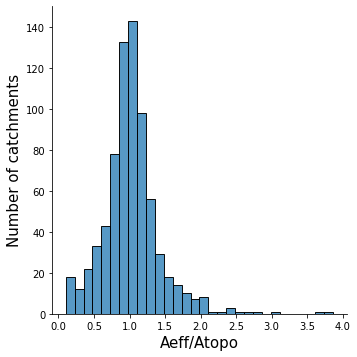

In [25]:
# Checking the distribution of the ratio
# Apparently there is at least one catchment with strange ratios (need to investigate)

plt.figure(figsize=(4,4), dpi=300)
ax = sns.displot(df_merged, x='Aeff/Atopo', bins=30)

plt.xlabel('Aeff/Atopo', fontsize=15)
plt.ylabel('Number of catchments', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)



plt.legend([],[], frameon=False)

# ax.savefig('histograma_AeffAtopo_v2.png', dpi=300)

<Figure size 1200x1200 with 0 Axes>

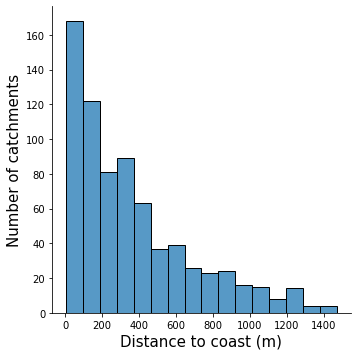

<Figure size 1200x1200 with 0 Axes>

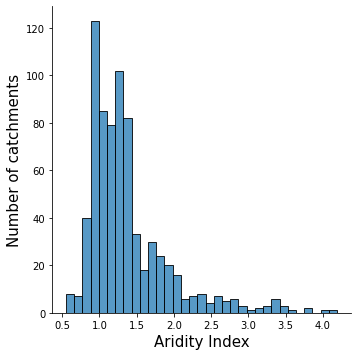

<Figure size 1200x1200 with 0 Axes>

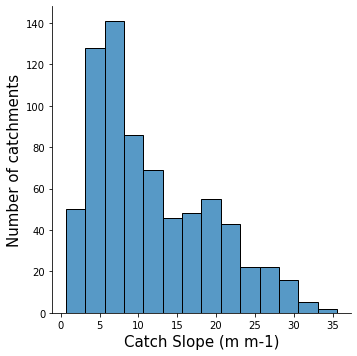

<Figure size 1200x1200 with 0 Axes>

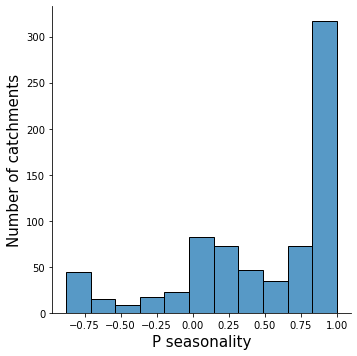

<Figure size 1200x1200 with 0 Axes>

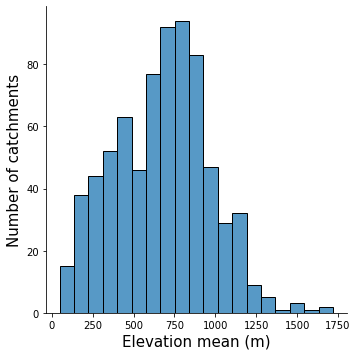

<Figure size 1200x1200 with 0 Axes>

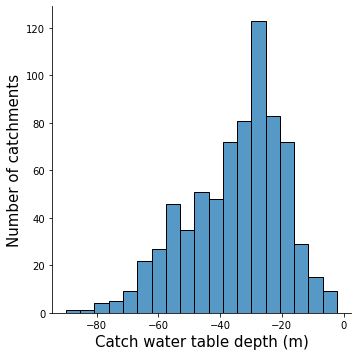

<Figure size 1200x1200 with 0 Axes>

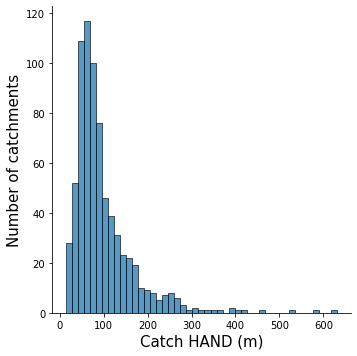

In [26]:
v = ['dist_coast'] + ['aridity_index', 'catch_slope','p_seasonality','elev_mean','catch_wtd','catch_hand']
label = ['Distance to coast (m)', ]
label_variables = ['Aridity Index', 'Catch Slope (m m-1)', 'P seasonality','Elevation mean (m)','Catch water table depth (m)','Catch HAND (m)']
# hist_color = '#F0C6C9'

for i, l in zip(v, label+label_variables):
    plt.figure(figsize=(4,4), dpi=300)

    ax = sns.displot(df_merged, x=f'{i}',
#                      color=hist_color
                    )
#     ax.tick_params(labelsize=10)
#     ax[0].set_xlabel(f'{i}', fontsize=15)
#     ax.set_ylabel('Count', fontsize=15)
    plt.xlabel(f'{l}', fontsize=15)
    plt.ylabel('Number of catchments', fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    

    plt.legend([],[], frameon=False)

#     ax.savefig(f'histograma_{i}_v2.png', dpi=300)

In [27]:
plot_variables = ['aridity_index', 'catch_slope','p_seasonality','elev_mean','catch_wtd','catch_hand']
label_variables = ['Aridity Index', 'Catch Slope', 'P seasonality','Elevation mean','Catch water table depth','Catch HAND']

In [28]:
from scipy.stats import spearmanr, pearsonr

In [29]:
df_merged[plot_variables].corr(method='pearson')

,aridity_index,catch_slope,p_seasonality,elev_mean,catch_wtd,catch_hand
aridity_index,1.000000,-0.273467,-0.007623,-0.156128,-0.121568,-0.210657
catch_slope,-0.273467,1.000000,0.325369,0.418033,-0.802488,0.812563
p_seasonality,-0.007623,0.325369,1.000000,0.627291,-0.256804,0.282092
elev_mean,-0.156128,0.418033,0.627291,1.000000,-0.339157,0.515222
catch_wtd,-0.121568,-0.802488,-0.256804,-0.339157,1.000000,-0.749029
catch_hand,-0.210657,0.812563,0.282092,0.515222,-0.749029,1.000000


In [30]:
df_merged[plot_variables].corr(method='spearman')

,aridity_index,catch_slope,p_seasonality,elev_mean,catch_wtd,catch_hand
aridity_index,1.000000,-0.289738,0.249240,-0.111263,-0.084495,-0.193785
catch_slope,-0.289738,1.000000,0.271720,0.419106,-0.758900,0.883363
p_seasonality,0.249240,0.271720,1.000000,0.613670,-0.172007,0.318529
elev_mean,-0.111263,0.419106,0.613670,1.000000,-0.296238,0.540232
catch_wtd,-0.084495,-0.758900,-0.172007,-0.296238,1.000000,-0.804389
catch_hand,-0.193785,0.883363,0.318529,0.540232,-0.804389,1.000000


In [31]:
for i in plot_variables:
    spearman = spearmanr( df_merged['ECI'],df_merged[i])
    pearson = pearsonr( df_merged['ECI'],df_merged[i])
    print()
    print(i,'\t',spearman,'\n\t\tPearson',pearson)


aridity_index 	 SpearmanrResult(correlation=-0.4674317620340262, pvalue=4.624839858115332e-41) 
		Pearson (-0.5971626517393898, 4.917069408713619e-72)

catch_slope 	 SpearmanrResult(correlation=0.5149803953737007, pvalue=6.921506550442165e-51) 
		Pearson (0.44914142616476804, 1.1253416169110935e-37)

p_seasonality 	 SpearmanrResult(correlation=0.155818172064714, pvalue=2.2619909058724528e-05) 
		Pearson (0.28605886881145515, 2.8537391209260484e-15)

elev_mean 	 SpearmanrResult(correlation=0.2840936532815741, pvalue=4.486476959321663e-15) 
		Pearson (0.3048270866962936, 3.1602234619618503e-17)

catch_wtd 	 SpearmanrResult(correlation=-0.2699487619034372, pvalue=1.0491000209837037e-13) 
		Pearson (-0.19087348640329016, 1.9209576603136648e-07)

catch_hand 	 SpearmanrResult(correlation=0.4825448720866539, pvalue=5.107432663915183e-44) 
		Pearson (0.3932278821154972, 1.614241773523911e-28)


C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py

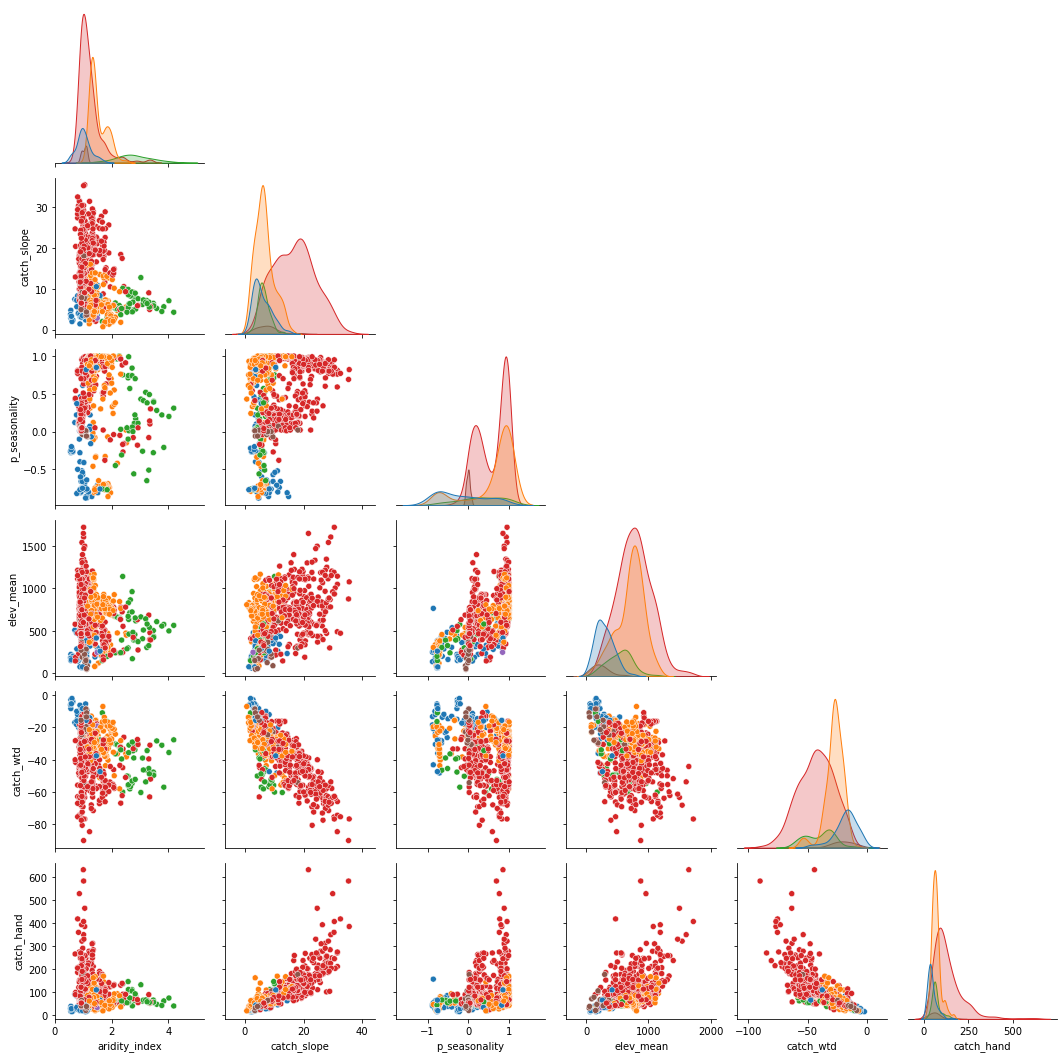

In [32]:
g = sns.PairGrid(vars=plot_variables, data=df_merged, hue='gauge_biome', diag_sharey=False, corner=True)
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.kdeplot, fill=True)
# g.savefig('variables_variables_corr.png', dpi=300)

In [34]:
plot_variables

['aridity_index',
 'catch_slope',
 'p_seasonality',
 'elev_mean',
 'catch_wtd',
 'catch_hand']

In [35]:
corr_s = spearmanr(df_merged[plot_variables])

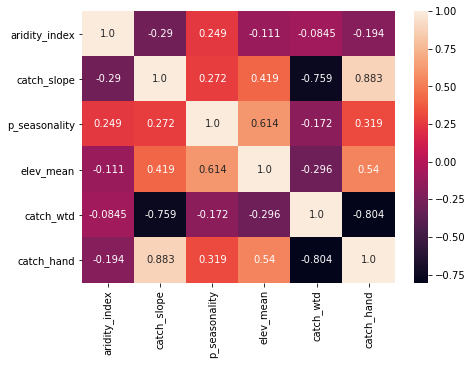

In [36]:
plt.figure(figsize=(7,5))
pearson_corr = sns.heatmap(corr_s[0], annot=True,xticklabels=plot_variables, yticklabels=plot_variables, fmt='.3')
# pearson_corr.get_figure().savefig('spearman_corr.png')
# plt.tight_layout()

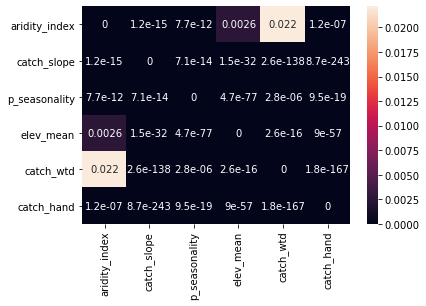

In [37]:
pearson_pvalue=sns.heatmap(corr_s[1], annot=True,xticklabels=plot_variables, yticklabels=plot_variables)
# pearson_pvalue.get_figure().savefig('spearman_pvalue.png')

In [38]:
corr_p = pearsonr(x=df_merged[plot_variables[0]], y=df_merged[plot_variables[1]])
print(corr_p)

(-0.27346714426156826, 4.8719270237363663e-14)


In [39]:
for i in plot_variables:
    for j in plot_variables:
        print(i, j)
        print(pearsonr(x=df_merged[i], y=df_merged[j]))

aridity_index aridity_index
(1.0, 0.0)
aridity_index catch_slope
(-0.27346714426156826, 4.8719270237363663e-14)
aridity_index p_seasonality
(-0.007623387918176555, 0.8367548669206727)
aridity_index elev_mean
(-0.15612832538094154, 2.1775300812076292e-05)
aridity_index catch_wtd
(-0.12156816570899734, 0.0009739162802040146)
aridity_index catch_hand
(-0.21065659706274553, 8.495778374971967e-09)
catch_slope aridity_index
(-0.27346714426156826, 4.8719270237363663e-14)
catch_slope catch_slope
(1.0, 0.0)
catch_slope p_seasonality
(0.32536947154720963, 1.550127246896569e-19)
catch_slope elev_mean
(0.41803330812696515, 2.2778475358625947e-32)
catch_slope catch_wtd
(-0.8024879140056672, 4.225751846468526e-166)
catch_slope catch_hand
(0.8125627444264092, 1.5653759901628913e-173)
p_seasonality aridity_index
(-0.007623387918176555, 0.8367548669206727)
p_seasonality catch_slope
(0.32536947154720963, 1.550127246896569e-19)
p_seasonality p_seasonality
(1.0, 0.0)
p_seasonality elev_mean
(0.62729130547

C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py

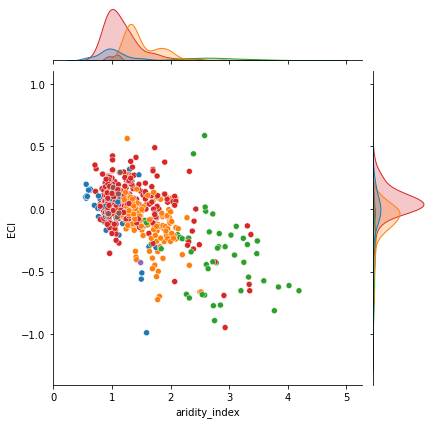

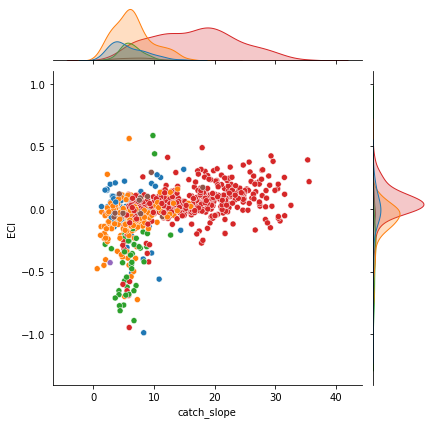

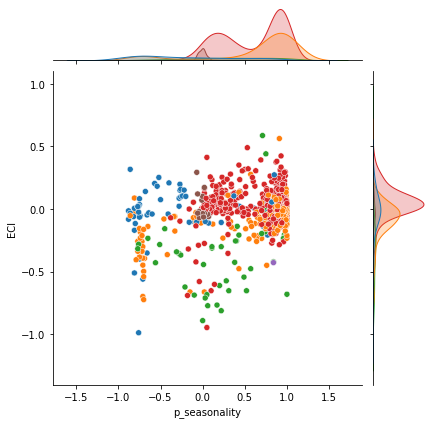

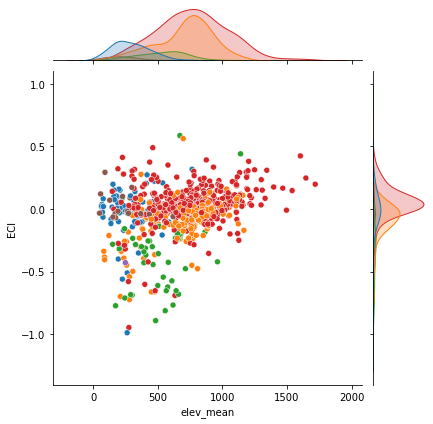

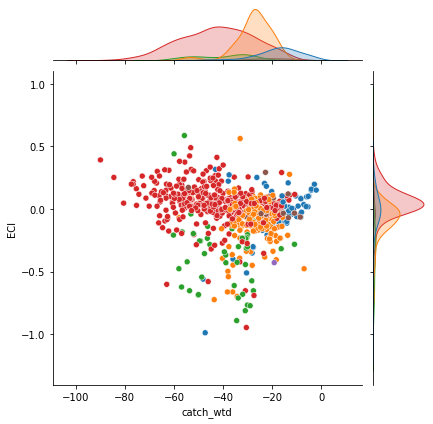

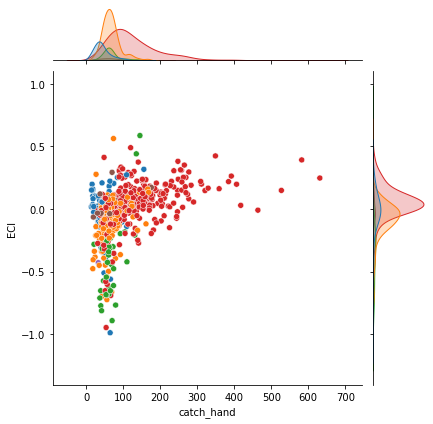

In [33]:
for variable in plot_variables:
    ax = sns.jointplot(x=variable, y='ECI', hue='gauge_biome',
                       data=df_merged, legend=False
                      )



C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\seaborn\distributions.py

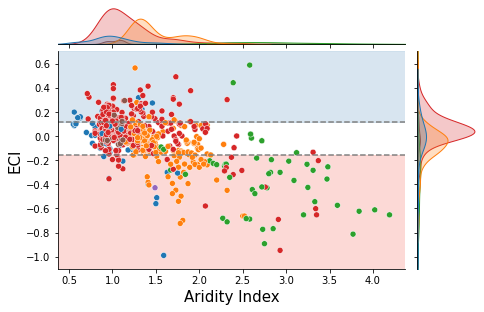

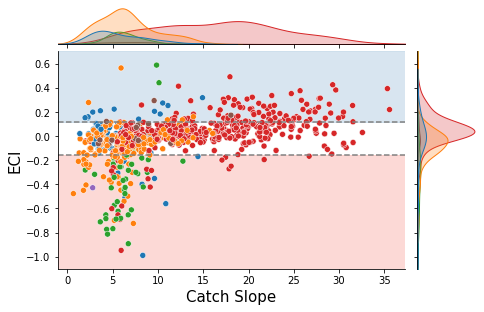

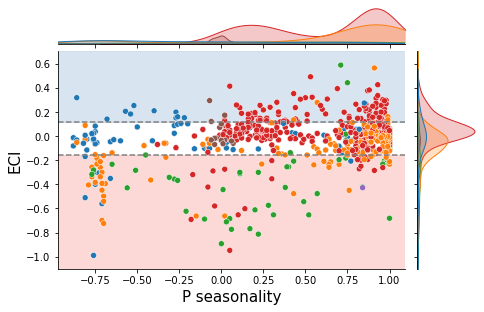

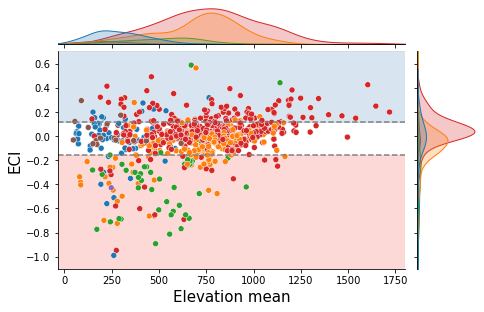

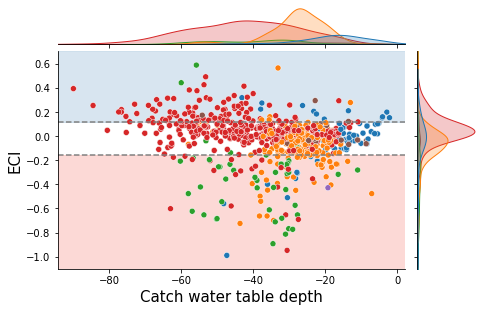

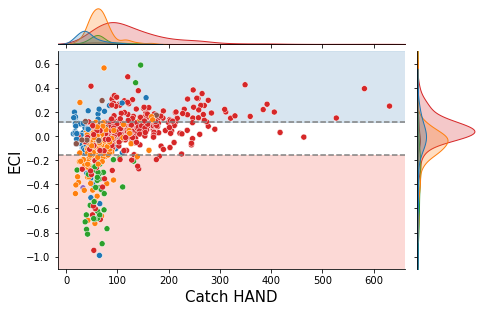

In [36]:
max_ratio_eci = 0.113943
min_ratio_eci = -0.1549
# Fazendo loop de várias variavies
for variable, xlabel in zip(plot_variables, label_variables):
    # Inicio do JointGrid
    g = sns.JointGrid()
    # Especificar tamanho
    g.fig.set_figwidth(6.5)
    g.fig.set_figheight(4)
    
#     s=10
    #  Scatter plot para a figura da nuvem de pontos
    sns.scatterplot(
                    # Variaveis
                    x=variable,y='ECI', hue='gauge_biome',
                    # Inserindo Dataframe
                    data=df_merged, 
                    # Aqui especifica que a o scatterplot é a img do meio 
                    ax=g.ax_joint, 
                    # Atributos do scatter
                    legend=False,
#                     s=s
    )
    #  Distribuição do eixo x e y
    sns.kdeplot(x=variable, hue='gauge_biome',
                data=df_merged, 
                # Definindo qual ax é (no casa é o x)
                ax=g.ax_marg_x, 
                # Atributos da parte da distribuição x
                legend=False, fill=True)
    sns.kdeplot(y='ECI', hue='gauge_biome',
                data=df_merged, 
                # Definindo qual ax é (no casa é o y)
                ax=g.ax_marg_y, 
                # Atributos da parte da distribuição y
                legend=False, fill=True)
    
    # Adicionando algumas faixas para a figura central (scatterplot) utilizando funções do matplotlib
    g.ax_joint.axhspan(min_ratio_eci,-1.1,alpha=0.5,color='#fbb4ae',zorder=0)
    g.ax_joint.axhspan(max_ratio_eci,0.7,alpha=0.5,color='#b3cde3',zorder=0)
    g.ax_joint.axhline(max_ratio_eci, ls='--',color='gray')
    g.ax_joint.axhline(min_ratio_eci, ls='--',color='gray')       

    # Definidno parâmetros dos eixos
    g.ax_joint.tick_params(labelsize=10)
    g.ax_joint.set_xlabel(f'{xlabel}', fontsize=15)
    g.ax_joint.set_ylabel('ECI', fontsize=15)
    g.ax_joint.set_ylim((-1.1,0.7))
    
    # Definindo parâmetros de limite da figura
    ylimit_min = df_merged[variable].min()
    ylimit_max = df_merged[variable].max()
    range_ylim = ylimit_max - ylimit_min
    g.ax_joint.set_xlim((ylimit_min-0.05*range_ylim, ylimit_max+0.05*range_ylim))
    
    # Salvando figura
#     g.savefig(f'eci_variables_{variable}_s{s}.png', dpi=300)


In [39]:
df_merged['ECI'].min(), df_merged['ECI'].max()

(-0.9890046156985369, 0.5873367345072557)

In [40]:
# Plot and looping throught the variables
azul_escuro = '#0906E2'
azul_claro = '#818BC2'
vermelho_escuro = '#B80203'
vermelho_claro = '#F0C6C9'

max_ratio_eci = 0.113943
min_ratio_eci = -0.1549

for variable, xlabel in zip(plot_variables, label_variables):
    plt.figure(figsize=(6.5,4))
    ax.axhspan(min_ratio_eci,-1.1,alpha=0.5,color='#fbb4ae',zorder=0)
    ax.axhspan(max_ratio_eci,0.7,alpha=0.5,color='#b3cde3',zorder=0)
    ax = sns.scatterplot(x=variable, y='ECI',
    #                      hue='substantial_eci',
                         hue='gauge_biome',
#                          style='substantial_eci',
                         
                         data=df_merged, 
                         markers=['^','P','v','s'],
    #                      palette=[azul_claro,azul_escuro ,vermelho_claro, vermelho_escuro],
                         alpha=1,
                        )

    ax.axhline(max_ratio_eci, ls='--',color='gray')
    ax.axhline(min_ratio_eci, ls='--',color='gray')
#     ax.axhspan(min_ratio_eci,-1.1,alpha=1,color='#fbb4ae',zorder=0)
#     ax.axhspan(max_ratio_eci,0.7,alpha=1,color='#b3cde3',zorder=0)
    ax.tick_params(labelsize=10)
    ax.set_xlabel(f'{xlabel}', fontsize=15)
    ax.set_ylabel('ECI', fontsize=15)
    ax.set_ylim((-1.1,0.7))

    plt.legend([],[], frameon=False)

    # ax.figure.savefig(f'{variable}_eci.png', dpi=300)
#     ax.figure.savefig(f'{variable}_eci_biome_733.png', dpi=300)
    # ax.figure.savefig(f'{variable}_eci_biome_gl.png', dpi=300)
    

AttributeError: 'JointGrid' object has no attribute 'axhspan'

<Figure size 468x288 with 0 Axes>